In [1]:
# These two lines are necessary only if GemPy is not installed via pip
import sys, os
sys.path.append(r'../../gempy/')
#sys.path.append(r'/Users/nijan/Documents/git/gempy/')

# Importing GemPy
import gempy as gp
from gempy.assets import topology as tp
from gempy.bayesian.fields import compute_prob, calculate_ie_masked

# Importing auxilary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# For embedding matplotlib figures
#%matplotlib qt5
%matplotlib inline

# Import improved plotting features
from gempy.plot import visualization_2d as vv
from gempy.plot import vista

import seaborn as sn

In [2]:
## progress bar
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Model Initialization
We import the base model with its topography etc.

In [3]:
model_path = '../models/20210319_MC_no_middle_filling/'

geo_model = gp.load_model('Graben_base_model', path=model_path,
                         recompile=False)

Active grids: ['regular']
Active grids: ['regular' 'topography']


In [4]:
geo_model.get_additional_data()

values
Structure isLith                                                          True
          isFault                                                         True
          number faults                                                      5
          number surfaces                                                   11
          number series                                                     10
          number surfaces per series            [1, 1, 1, 1, 1, 3, 1, 1, 1, 0]
          len surfaces surface_points  [6, 8, 12, 8, 6, 8, 14, 14, 26, 24, 24]
          len series surface_points        [6, 8, 12, 8, 6, 36, 26, 24, 24, 0]
          len series orientations           [2, 2, 6, 4, 2, 12, 16, 12, 10, 0]
Options   dtype                                                        float64
          output                                                       geology
          theano_optimizer                                        fast_compile
          device                                                           cpu
          verbosity                                                       None
Kriging   range                                                        32190.8
          $C_o$                                                    2.46726e+07
          drift equations                       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Rescaling rescaling factor                                             56916.7
          centers                          [14239.166495, 6900.0, -2581.92853]

In [5]:
# adapt kriging to the parameters of previous example
# decrease the kriging range
geo_model.modify_kriging_parameters('range', 20000.)
geo_model.modify_kriging_parameters('$C_o$', 2e5)
#geo_model.modify_surface_points('all', smooth=1e-6)

# Set the interpolator function
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[],
                         update_kriging=False);

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  5
Compilation Done!
Kriging values: 
                                          values
range                                     20000
$C_o$                                    200000
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [6]:
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=True)

C:\Users\brigg\miniconda3\envs\env_gempy\lib\site-packages\gempy\core\solution.py:315: UserWarning: Surfaces not computed due to: No surface found at the given iso value.. The surface is: Series: No surface found at the given iso value.; Surface Number:8
  '; Surface Number:' + str(s_n))
C:\Users\brigg\miniconda3\envs\env_gempy\lib\site-packages\gempy\core\solution.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.geological_map = np.array([values[0][:, l0: l1], values[4][:, l0: l1].astype(float)])


In [7]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
9,Thrust1_south,Thrust1_series,1,#5DA629,1
10,Thrust2_south,Thrust2_series,1,#5DA629,2
0,Fault2,Fault2_series,1,#015482,3
1,Fault5,Fault5_series,1,#015482,4
2,Fault6,Fault6_series,1,#015482,5
6,Tertiary,Post_tectonic_series,1,#dbdbac,6
8,Pink,Post_tectonic_series,2,#e588f3,7
7,Orange,Post_tectonic_series,3,#ff792b,8
5,Mesozoic,Detachement,1,#725c9a,9
4,Upper-filling,Syn_tectonic_series2,1,#cfc199,10


## Add Gravity grid

In [5]:
np.__version__

'1.19.1'

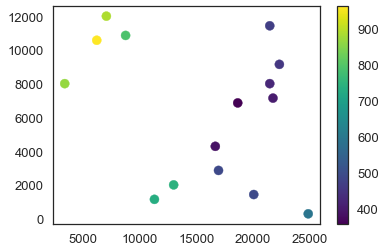

In [4]:
# distribute stations
import random
np.random.seed(58)
station_indices = np.random.randint(0, high=4999, size=15)
#random.seed(58)
#station_indices = random.sample(range(0, 4999), 15)
station_coordinates = geo_model._grid.topography.values[station_indices, :]

cs = plt.scatter(station_coordinates[:,0], station_coordinates[:,1], c=station_coordinates[:,2], cmap='viridis')
plt.colorbar(cs)

In [8]:
from gempy.assets.geophysics import GravityPreprocessing
geo_model.set_centered_grid(station_coordinates,  resolution = [10, 10, 15], radius=6000)
g = GravityPreprocessing(geo_model.grid.centered_grid)
tz = g.set_tz_kernel()

Active grids: ['regular' 'topography' 'centered']


In [9]:
# add densities - from abdelfettah 2014
densities = [0, 0, 0, 0, 0, 2.5, 2.53, 2.55, 
             2.60, 2.47, 2.57, 2.67]
geo_model.add_surface_values(densities, ['density'])

,surface,series,order_surfaces,color,id,density
9,Thrust1_south,Thrust1_series,1,#5DA629,1,0.000000
10,Thrust2_south,Thrust2_series,1,#5DA629,2,0.000000
0,Fault2,Fault2_series,1,#015482,3,0.000000
1,Fault5,Fault5_series,1,#015482,4,0.000000
2,Fault6,Fault6_series,1,#015482,5,0.000000
6,Tertiary,Post_tectonic_series,1,#dbdbac,6,2.500000
8,Pink,Post_tectonic_series,2,#e588f3,7,2.530000
7,Orange,Post_tectonic_series,3,#ff792b,8,2.550000
5,Mesozoic,Detachement,1,#725c9a,9,2.600000
4,Upper-filling,Syn_tectonic_series2,1,#cfc199,10,2.470000


In [10]:
gp.set_interpolator(geo_model, output=['gravity'], theano_optimizer='fast_run', update_kriging=False)

Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  5
Compilation Done!
Kriging values: 
                                          values
range                                     20000
$C_o$                                    200000
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [96]:
sol = gp.compute_model(geo_model)
grav = sol.fw_gravity

C:\Users\brigg\miniconda3\envs\env_gempy\lib\site-packages\gempy\core\solution.py:315: UserWarning: Surfaces not computed due to: No surface found at the given iso value.. The surface is: Series: No surface found at the given iso value.; Surface Number:8
  '; Surface Number:' + str(s_n))
C:\Users\brigg\miniconda3\envs\env_gempy\lib\site-packages\gempy\core\solution.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.geological_map = np.array([values[0][:, l0: l1], values[4][:, l0: l1].astype(float)])


In [97]:
grav1 = grav.reshape(len(grav),1)
station_forw_grav = np.append(station_coordinates, grav1, axis=1)

In [98]:
np.savetxt('../models/20210322_forw_grav_seed58.csv', station_forw_grav, fmt='%.2f, %.2f, %.2f, %.5f')

## MC Variation

In [11]:
depth_zero = geo_model.surface_points.df['Z'].copy()
depth = depth_zero.copy()

In [12]:
graben_bot = geo_model.surface_points.df.query("surface=='Lower-filling' or surface=='Upper-filling'")

In [13]:
# mask_surfpoints = geo_model.surface_points.df.series.isin(faults)
gp.set_interpolator(geo_model, output=['gravity'], theano_optimizer='fast_run', update_kriging=False)
np.random.seed(1000)
lith_blocks = np.array([])
grav = dict()
edge_blocks = dict()
cent_blocks = dict()
depth = geo_model.surface_points.df['Z'].copy()
graben = list(graben_bot.index)
n_points = len(graben)
n_iterations = 500

geo_model._grid
#for i in range(n_iterations):
for i in log_progress(range(n_iterations), name='Models'):
    variation = np.random.normal(0, 250)
    Z = depth[graben] + np.random.normal(variation, 50, size=n_points)
    geo_model.modify_surface_points(graben, Z=Z)
    gp.compute_model(geo_model)
    edges, centroids = tp.compute_topology(geo_model)
    lith_blocks = np.append(lith_blocks, geo_model.solutions.lith_block)
    grav[f"Real_{i}"] = geo_model.solutions.fw_gravity
    edge_blocks[f"Real_{i}"] = edges
    cent_blocks[f"Real_{i}"] = centroids

lith_blocks = lith_blocks.reshape(n_iterations, -1)

Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  5
Compilation Done!
Kriging values: 
                                          values
range                                     20000
$C_o$                                    200000
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


C:\Users\brigg\miniconda3\envs\env_gempy\lib\site-packages\gempy\core\solution.py:315: UserWarning: Surfaces not computed due to: No surface found at the given iso value.. The surface is: Series: No surface found at the given iso value.; Surface Number:8
  '; Surface Number:' + str(s_n))
C:\Users\brigg\miniconda3\envs\env_gempy\lib\site-packages\gempy\core\solution.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.geological_map = np.array([values[0][:, l0: l1], values[4][:, l0: l1].astype(float)])


In [14]:
np.savetxt('../models/20210319_MC_no_middle_filling/lith_block_samples_run02_500real_rseed1000', lith_blocks, fmt='%d')

In [15]:
gravdf = pd.DataFrame.from_dict(grav)

In [16]:
gravdf["X"] = station_coordinates[:,0]
gravdf["Y"] = station_coordinates[:,1]
gravdf["Z"] =station_coordinates[:,2]

In [17]:
gravdf.to_csv("../models/20210319_MC_no_middle_filling/MC_grav_simulations_run02_500_reals_rseed1000_250+50mstd.csv", index=False)

In [27]:
import pickle

fp = open('topology_run02_rseed1000.p', 'wb')
pickle.dump(cent_blocks, fp, protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(edge_blocks, fp, protocol=pickle.HIGHEST_PROTOCOL)
fp.close()

In [26]:
type(cent_blocks['Real_0'])

dict

In [19]:
dist = np.array([])
for i in range(10000):
    dist = np.append(dist, np.random.normal(0, 100))

sn.distplot(dist)